NOTE:
The psnr value ,mse and mae is recalculated at the end and this model is later saved as low_light_image_denoising_model.h5 so it dosent have to be trained again .Furthumore this is used in main.py
final results:
Mean MSE: 0.0037566144540100567
Mean PSNR: 24.99113215169432
Mean MAE: 0.04323466867208481

In [25]:
# fulfilling the initalization
# !pip install opencv-python
import os
import numpy as np
import tensorflow as tf
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,concatenate,Cropping2D,Conv2DTranspose,BatchNormalization,Dropout
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,      ReduceLROnPlateau
from PIL import Image, UnidentifiedImageError
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# hyperparams
batch_size=32
# 64 exceed the memory capacity dont usse
img_size=256
epochs=100

def load_images(image_dir, image_size=(img_size, img_size)):
    images = []
    for img_name in sorted(os.listdir(image_dir)):
        img_path=os.path.join(image_dir, img_name)
        
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img)/255 
        images.append(img)
        # augmentation x more samples
        img1=cv.flip(img,1)
        images.append(img_to_array(img1))
        img2=cv.flip(img,-1)
        images.append(img_to_array(img2))
        img3=cv.rotate(img,cv.ROTATE_90_CLOCKWISE)
        images.append(img_to_array(img3))
        img4=cv.rotate(img,cv.ROTATE_90_COUNTERCLOCKWISE)
        images.append(img_to_array(img4))
            
       
    return np.array(images)



In [26]:
# def custom_augment(img):
#     aug_imgs = []
#     aug_imgs.append(img)
#     aug_imgs.append(img[:, ::-1, :])  # top to bottom
#     aug_imgs.append(img[::-1, :, :])  # left to rigt
#     aug_imgs.append(np.rot90(img))  # 90 * rotation
#     aug_imgs.append(np.rot90(img, 3))  # 90x3 * rotation
#     return aug_imgs

In [27]:
def unet(input_shape=(img_size,img_size,3)):
    inputs=Input(input_shape)
    
    #encoder part
    d1 = layers.Conv2D(128, (3, 3), padding='same', strides=2)(inputs)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.LeakyReLU()(d1)
    
    d2 = layers.Conv2D(128, (3, 3), padding='same', strides=2)(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.LeakyReLU()(d2)
    
    d3 = layers.Conv2D(256, (3, 3), padding='same', strides=2)(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.LeakyReLU()(d3)
    
    d4 = layers.Conv2D(512, (3, 3), padding='same', strides=2)(d3)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.LeakyReLU()(d4)
    
    #base part 
    d5 = layers.Conv2D(512, (3, 3), padding='same', strides=2)(d4)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.LeakyReLU()(d5)

    u1 = layers.Conv2DTranspose(512, (3, 3), padding='same', strides=2)(d5)
    u1 = layers.Dropout(0.1)(u1)
    u1 = layers.LeakyReLU()(u1)
    u1 = layers.concatenate([u1, d4])

    #decoder part
    #connect it parallel to the encoders  
    #4-1,3-2,2-3,4-1  order ,size same  
    
    
    u2 = layers.Conv2DTranspose(256, (3, 3), padding='same', strides=2)(u1)
    u2 = layers.Dropout(0.1)(u2)
    u2 = layers.LeakyReLU()(u2)
    u2 = layers.concatenate([u2, d3])
    
    u3 = layers.Conv2DTranspose(128, (3, 3), padding='same', strides=2)(u2)
    u3 = layers.Dropout(0.1)(u3)
    u3 = layers.LeakyReLU()(u3)
    u3 = layers.concatenate([u3, d2])
    
    u4 = layers.Conv2DTranspose(128, (3, 3), padding='same', strides=2)(u3)
    u4 = layers.Dropout(0.1)(u4)
    u4 = layers.LeakyReLU()(u4)
    u4 = layers.concatenate([u4, d1])
    
    u5 = layers.Conv2DTranspose(3, (3, 3), padding='same', strides=2)(u4)
    u5 = layers.Dropout(0.1)(u5)
    u5 = layers.LeakyReLU()(u5)
    u5 = layers.concatenate([u5, inputs])
    
    output = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)
    return Model(inputs=inputs, outputs=output)

In [32]:
def train_model():
    clean_images=load_images('./Train/high')   
    # cap T dont miss also augment=Truenot working

    noisy_images=load_images('./Train/low')
    #dividing the data into train and validn sets

    model=unet(input_shape=(img_size,img_size,3))
    #augmenting 
    # ...alreaady done but this can also be used test out both 

    # datagen=ImageDataGenerator( 
    #     rotation_range=30,
    #     width_shift_range=0.1,
    #     height_shift_range=0.1,
    #     shear_range=0.2,
    #     zoom_range=0.2,
    #     horizontal_flip=True,
    #     vertical_flip=True,
    #     fill_mode='nearest'
    # )
   
    # train_generator=datagen.flow(noisy_images,clean_images,batch_size=batch_size)  

    
    model.compile(optimizer=RMSprop(learning_rate=0.001),loss='mean_absolute_error',metrics=['accuracy'])
    # since mae,mse asked no req for square
    # ramsprop as optimiser test once if not then adam
    
    early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
    lr_reduction=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=0.00001)

    model.fit(noisy_images,clean_images,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(noisy_images,clean_images),callbacks=[early_stopping,lr_reduction])

    return model


In [33]:
def plot_images(low, high, predicted):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("low")
    plt.imshow(low)
    plt.subplot(1, 3, 2)
    plt.title("high ")
    plt.imshow(high)
    plt.subplot(1, 3, 3)
    plt.title("predicted")
    plt.imshow(predicted)
    plt.show()

In [36]:
def evaluate_model(model, clean_images, noisy_images):
    predictions = model.predict(noisy_images)
    mse_scores = [mse(clean, pred) for clean, pred in zip(clean_images, predictions)]
    psnr_scores = [psnr(clean, pred) for clean, pred in zip(clean_images, predictions)]
    mae_scores = [mae(clean.flatten(), pred.flatten()) for clean, pred in zip(clean_images, predictions)]

    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean PSNR: {np.mean(psnr_scores)}")
    print(f"Mean MAE: {np.mean(mae_scores)}")

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 515s 7s/step - accuracy: 0.3343 - loss: 0.2363 - val_accuracy: 0.4537 - val_loss: 0.2532 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.5089 - loss: 0.1521 - val_accuracy: 0.3867 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 508s 7s/step - accuracy: 0.5577 - loss: 0.1448 - val_accuracy: 0.2991 - val_loss: 0.1619 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.5766 - loss: 0.1333 - val_accuracy: 0.2778 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 494s 6s/step - accuracy: 0.5880 - loss: 0.1302 - val_accuracy: 0.3293 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.6096 - loss: 0.1261 - val_accuracy: 0.4973 - val_loss: 0.1459 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 518s 7s/step - accuracy: 0.6225 - loss: 0.1222 - 

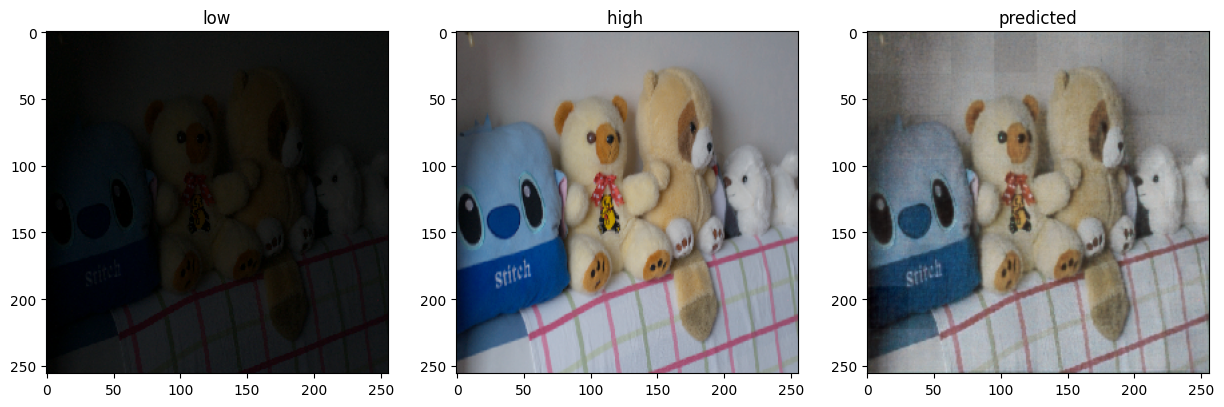

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


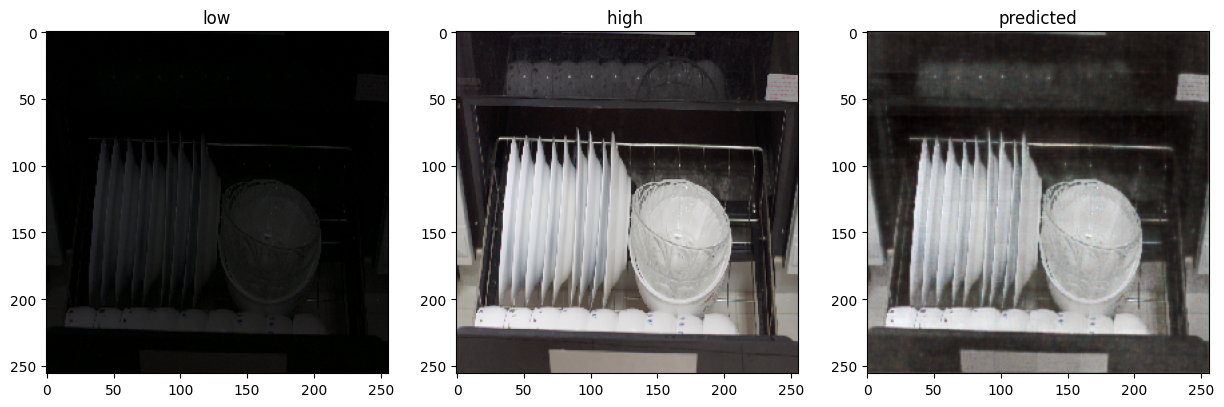

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


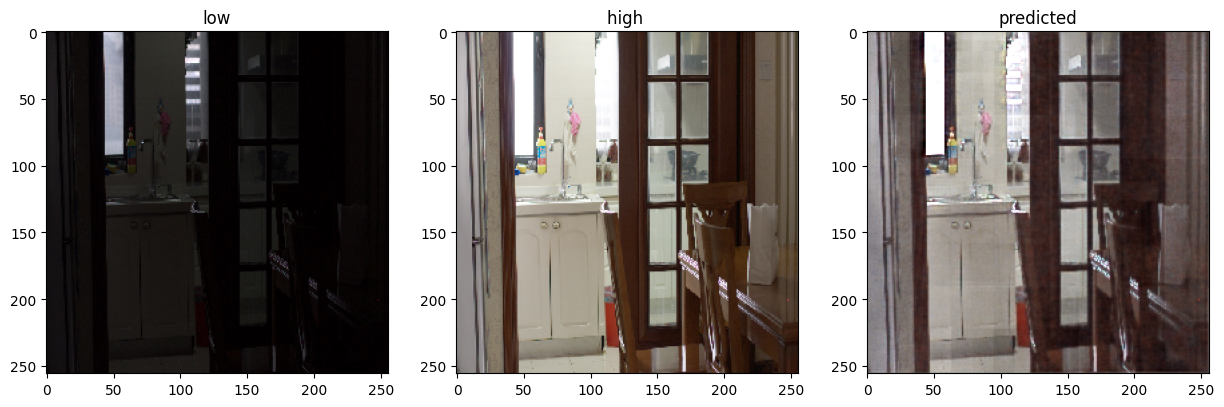

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


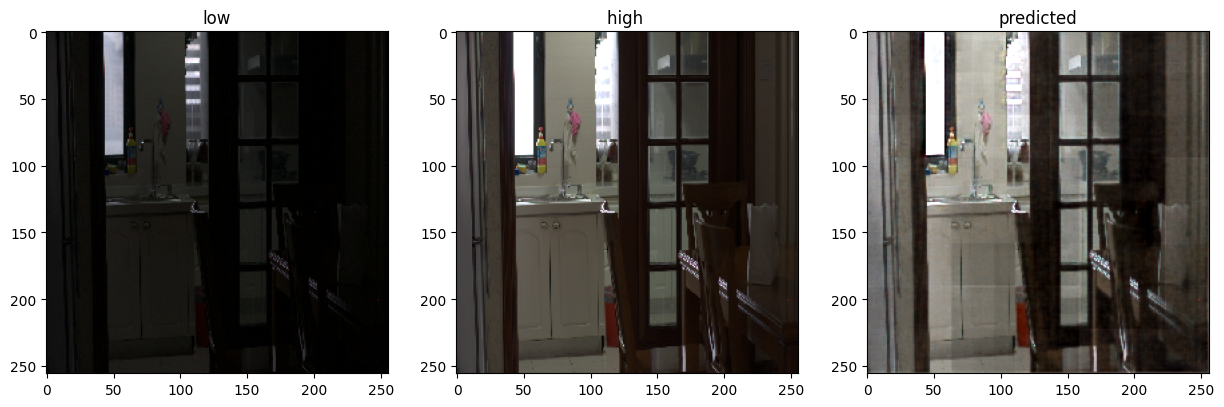

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


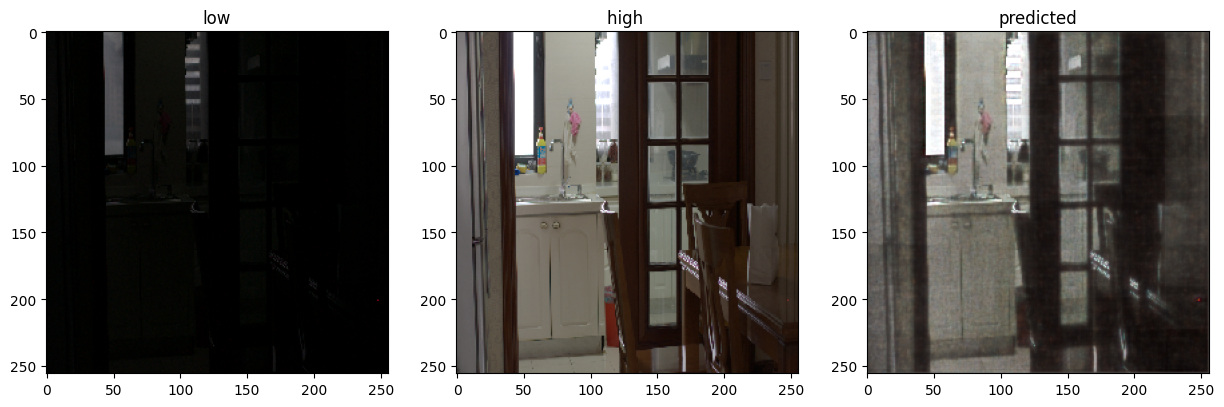

In [35]:

if __name__ == '__main__':
    model =train_model()
    
    clean_images=load_images('./Train/high')
    noisy_images=load_images('./Train/low')
    
    evaluate_model(model, clean_images, noisy_images)
    
    for i   in range (0, 25, 5):
        predicted=np.clip(model.predict(noisy_images[i].reshape(1  , img_size, img_size, 3)), 0.0, 1.0).reshape(img_size, img_size, 3)
        plot_images(noisy_images[i], clean_images[i], predicted)
    

In [37]:
evaluate_model(model, clean_images, noisy_images)

76/76 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step
Mean MSE: 0.0037566144540100567
Mean PSNR: 24.99113215169432
Mean MAE: 0.04323466867208481


In [38]:
# saving model finally  not doing again
model.save('low_light_image_denoising_model.h5')

print("************************************************Model saved**********************************************************************")

************************************************Model saved**********************************************************************
